In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Backup/EVP/S9/S9_quiz

In [0]:
from __future__ import print_function
import torch
from torch.optim.lr_scheduler import OneCycleLR



# Setting Seed for Reproducibility

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Data Loader


In [0]:
import torchvision
from torchvision import datasets, transforms

In [6]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomCrop(size=32, padding=4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  transforms.RandomErasing()
                                       ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataloader_args = dict(batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


train_loader = torch.utils.data.DataLoader(trainset,shuffle=True, **dataloader_args)
test_loader = torch.utils.data.DataLoader(testset, shuffle=False,  **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualise Data

plane   dog  deer  deer


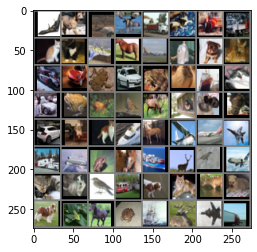

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model Summary


In [0]:
from vision.models.QuizDNN import QuizDNN

try:
  from torchsummary import summary
except:
  !pip install torchsummary
  from torchsummary import summary

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = QuizDNN().to(device)
summary(model, input_size=(3,32,32))

cuda
Current Date/Time:  2020-03-21 19:14:13.379590
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]              48
            Conv2d-2           [-1, 16, 32, 32]           2,304
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
              ReLU-5           [-1, 16, 32, 32]               0
           Dropout-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]             512
            Conv2d-9           [-1, 32, 16, 16]           9,216
           Conv2d-10           [-1, 32, 16, 16]           9,216
           Conv2d-11           [-1, 32, 16, 16]           9,216
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Train and Evaluate Model

In [12]:
from vision.train.train_evaluate import Train
import torch.nn as nn
import torch.optim as optim

CUDA Available? True


## Initialising and setting hyper-parameters


In [13]:
EPOCHS = 40
learning_rate = 0.01
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = QuizDNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler =None
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)


Current Date/Time:  2020-03-21 19:14:13.423340


## Creating Config for Training 

In [0]:
config_list ={
    "device": device,
    "model": model,
    "EPOCHS": EPOCHS,
    "criterion": criterion,
    "optimizer": optimizer,
    "scheduler": scheduler,
    "logger": None,
    "train_loader": train_loader,
    "test_loader" : test_loader,
    "flag_misclassified_images": False
}

## Create obj of Train and run for training


In [15]:
cifar_model_train = Train(config_list)
cifar_model_train.run_model()

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH:1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.279077172279358 Batch_id=781 Accuracy=43.25: 100%|██████████| 782/782 [00:17<00:00, 45.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 4468/10000 (44.68%)

EPOCH:2


Loss=1.0864818096160889 Batch_id=781 Accuracy=56.48: 100%|██████████| 782/782 [00:17<00:00, 44.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 5500/10000 (55.00%)

EPOCH:3


Loss=1.3699097633361816 Batch_id=781 Accuracy=60.65: 100%|██████████| 782/782 [00:17<00:00, 45.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 5321/10000 (53.21%)

EPOCH:4


Loss=1.2402592897415161 Batch_id=781 Accuracy=62.71: 100%|██████████| 782/782 [00:17<00:00, 44.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 4966/10000 (49.66%)

EPOCH:5


Loss=1.1591159105300903 Batch_id=781 Accuracy=63.87: 100%|██████████| 782/782 [00:17<00:00, 44.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 5757/10000 (57.57%)

EPOCH:6


Loss=1.822967290878296 Batch_id=781 Accuracy=65.64: 100%|██████████| 782/782 [00:17<00:00, 45.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 5455/10000 (54.55%)

EPOCH:7


Loss=0.8099313974380493 Batch_id=781 Accuracy=66.55: 100%|██████████| 782/782 [00:17<00:00, 44.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 4369/10000 (43.69%)

EPOCH:8


Loss=0.7690688371658325 Batch_id=781 Accuracy=67.26: 100%|██████████| 782/782 [00:17<00:00, 45.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 3912/10000 (39.12%)

EPOCH:9


Loss=0.9013286232948303 Batch_id=781 Accuracy=68.34: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 6189/10000 (61.89%)

EPOCH:10


Loss=0.5168591737747192 Batch_id=781 Accuracy=68.99: 100%|██████████| 782/782 [00:17<00:00, 45.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 5707/10000 (57.07%)

EPOCH:11


Loss=0.7866262197494507 Batch_id=781 Accuracy=69.76: 100%|██████████| 782/782 [00:17<00:00, 45.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 6323/10000 (63.23%)

EPOCH:12


Loss=1.3332011699676514 Batch_id=781 Accuracy=70.38: 100%|██████████| 782/782 [00:17<00:00, 45.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 5532/10000 (55.32%)

EPOCH:13


Loss=0.7597497701644897 Batch_id=781 Accuracy=71.11: 100%|██████████| 782/782 [00:17<00:00, 45.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 6977/10000 (69.77%)

EPOCH:14


Loss=0.6116546392440796 Batch_id=781 Accuracy=71.53: 100%|██████████| 782/782 [00:17<00:00, 45.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 7063/10000 (70.63%)

EPOCH:15


Loss=0.7400088906288147 Batch_id=781 Accuracy=72.26: 100%|██████████| 782/782 [00:17<00:00, 45.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 6673/10000 (66.73%)

EPOCH:16


Loss=0.8733246326446533 Batch_id=781 Accuracy=73.09: 100%|██████████| 782/782 [00:17<00:00, 44.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 4928/10000 (49.28%)

EPOCH:17


Loss=0.5034555792808533 Batch_id=781 Accuracy=73.10: 100%|██████████| 782/782 [00:17<00:00, 45.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 6797/10000 (67.97%)

EPOCH:18


Loss=0.9316793084144592 Batch_id=781 Accuracy=73.72: 100%|██████████| 782/782 [00:17<00:00, 45.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 7148/10000 (71.48%)

EPOCH:19


Loss=0.8239057064056396 Batch_id=781 Accuracy=74.17: 100%|██████████| 782/782 [00:17<00:00, 45.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 6912/10000 (69.12%)

EPOCH:20


Loss=1.123225450515747 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [00:17<00:00, 45.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 7055/10000 (70.55%)

EPOCH:21


Loss=1.1332334280014038 Batch_id=781 Accuracy=74.86: 100%|██████████| 782/782 [00:17<00:00, 45.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 7158/10000 (71.58%)

EPOCH:22


Loss=0.8726934194564819 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [00:17<00:00, 45.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 5912/10000 (59.12%)

EPOCH:23


Loss=1.0544443130493164 Batch_id=781 Accuracy=75.62: 100%|██████████| 782/782 [00:17<00:00, 45.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 7355/10000 (73.55%)

EPOCH:24


Loss=1.1435766220092773 Batch_id=781 Accuracy=76.26: 100%|██████████| 782/782 [00:17<00:00, 45.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 7175/10000 (71.75%)

EPOCH:25


Loss=0.4627472758293152 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:17<00:00, 45.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 6938/10000 (69.38%)

EPOCH:26


Loss=0.6389510035514832 Batch_id=781 Accuracy=77.11: 100%|██████████| 782/782 [00:17<00:00, 45.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 6418/10000 (64.18%)

EPOCH:27


Loss=0.7600013613700867 Batch_id=781 Accuracy=77.91: 100%|██████████| 782/782 [00:17<00:00, 45.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 7348/10000 (73.48%)

EPOCH:28


Loss=0.5414016246795654 Batch_id=781 Accuracy=78.47: 100%|██████████| 782/782 [00:17<00:00, 45.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7443/10000 (74.43%)

EPOCH:29


Loss=0.8317157626152039 Batch_id=781 Accuracy=78.86: 100%|██████████| 782/782 [00:17<00:00, 45.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 7404/10000 (74.04%)

EPOCH:30


Loss=0.4780600070953369 Batch_id=781 Accuracy=79.47: 100%|██████████| 782/782 [00:17<00:00, 45.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7808/10000 (78.08%)

EPOCH:31


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 7832/10000 (78.32%)

EPOCH:32


Loss=0.2992473542690277 Batch_id=781 Accuracy=80.52: 100%|██████████| 782/782 [00:17<00:00, 45.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7929/10000 (79.29%)

EPOCH:33


Loss=0.31381911039352417 Batch_id=781 Accuracy=81.49: 100%|██████████| 782/782 [00:17<00:00, 45.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8092/10000 (80.92%)

EPOCH:34


Loss=1.2133269309997559 Batch_id=781 Accuracy=82.23: 100%|██████████| 782/782 [00:17<00:00, 44.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8191/10000 (81.91%)

EPOCH:35


Loss=0.786124050617218 Batch_id=781 Accuracy=83.17: 100%|██████████| 782/782 [00:17<00:00, 45.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 8196/10000 (81.96%)

EPOCH:36


Loss=0.5877670645713806 Batch_id=781 Accuracy=83.75: 100%|██████████| 782/782 [00:17<00:00, 45.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8289/10000 (82.89%)

EPOCH:37


Loss=0.31903189420700073 Batch_id=781 Accuracy=84.10: 100%|██████████| 782/782 [00:17<00:00, 45.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8278/10000 (82.78%)

EPOCH:38


Loss=0.8388347625732422 Batch_id=781 Accuracy=84.79: 100%|██████████| 782/782 [00:17<00:00, 45.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8334/10000 (83.34%)

EPOCH:39


Loss=0.5291562080383301 Batch_id=781 Accuracy=84.92: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8320/10000 (83.20%)

EPOCH:40


Loss=0.3814195692539215 Batch_id=781 Accuracy=85.21: 100%|██████████| 782/782 [00:17<00:00, 45.58it/s]



Test set: Average loss: 0.0076, Accuracy: 8343/10000 (83.43%)



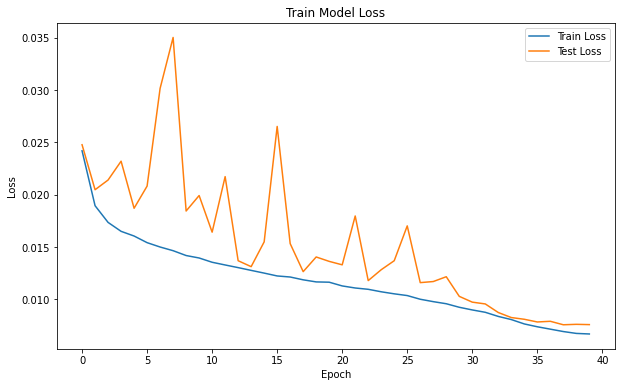

In [16]:
cifar_model_train.plot_loss_graph()

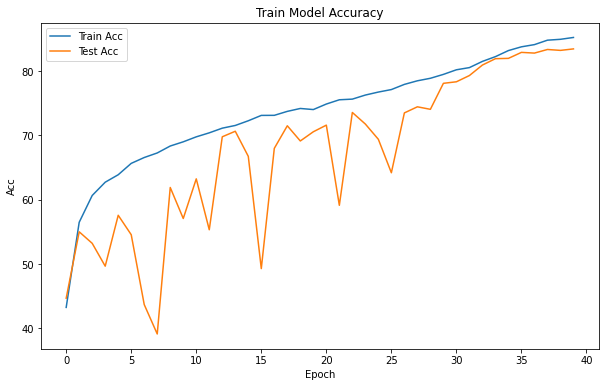

In [17]:
cifar_model_train.plot_acc_graph()

In [0]:
%matplotlib inline